In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re 

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
#from pyspark.sql.Column import isNull

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
spark

In [3]:
sns.set_context('talk')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook')

In [4]:
#load the dataset
data = spark.read.csv('en.openfoodfacts.org.products.csv',header=True,sep='\t')               

In [ ]:
#first look at the dataFrame
data.show(5)

In [ ]:
#available features
data.columns

In [ ]:
#a first look at how many non null data we have 
for c in data.columns:
    print('feature:',c,' has',data.filter(data[c].isNull()).count(),'missing data')

In [ ]:
#maybe you better your dataset to point out a lost of lost data

In [ ]:
#analyse and cleaning the data, choosing what to do according what data we have: FIRST WEEK

data.groupBy("ingredients_from_palm_oil_tags").count().orderBy('count',ascending=False).show(5)
from pyspark.sql import functions as F
#total = packaging.groupBy().agg(F.sum("count")).collect()
#the first analys on packaging we meant to be , it can not take place because the amount of null is way higher respect to the total

In [ ]:
data.groupBy(["brands","product_name"]).count().orderBy('count',ascending=False).where(data.brands.isNotNull()).filter("product_name=='Riz Long Grain'").show(10)

In [ ]:
data.groupBy().count().orderBy('count',ascending=False).show(5)

In [ ]:
data.groupBy("states").count().orderBy('count',ascending=False).show(5)

In [6]:
# STARTING:

#considering the groups 1 as food categories and some relevant features
data=data.groupBy(["pnns_groups_1","energy_100g","fat_100g","sugars_100g","proteins_100g","carbohydrates_100g","sodium_100g","salt_100g","product_name","packaging","ingredients_from_palm_oil_tags"]).count()
data.show()

+--------------------+-----------+--------+-----------+-------------+------------------+------------------+---------+--------------------+----------------+------------------------------+-----+
|       pnns_groups_1|energy_100g|fat_100g|sugars_100g|proteins_100g|carbohydrates_100g|       sodium_100g|salt_100g|        product_name|       packaging|ingredients_from_palm_oil_tags|count|
+--------------------+-----------+--------+-----------+-------------+------------------+------------------+---------+--------------------+----------------+------------------------------+-----+
|             unknown|        866|     6.7|        0.6|          8.9|              27.5|  0.15748031496063|      0.4|   Baguette Poitevin|            null|                          null|    1|
|Milk and dairy pr...|       null|    null|       null|         null|              null|              null|     null|          Sundae Mix|Plastique,Carton|                          null|    1|
|Cereals and potatoes|       1657| 

In [7]:
# cleaning the categories by removing null values and the unknown
dataClean=data.where(data.pnns_groups_1.isNotNull()).filter(data.pnns_groups_1!='unknown').drop('count')
dataClean.show()

+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|       pnns_groups_1|energy_100g|fat_100g|sugars_100g|proteins_100g|carbohydrates_100g|       sodium_100g|        salt_100g|        product_name|           packaging|ingredients_from_palm_oil_tags|
+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|Milk and dairy pr...|       null|    null|       null|         null|              null|              null|             null|          Sundae Mix|    Plastique,Carton|                          null|
|Cereals and potatoes|       1657|    11.1|       15.1|          8.3|              63.7| 0.673228346456693|             1.71|Gluten Free Melba...|        Carton,boîte|                          null|
|    

In [8]:
#looking at the unique values of the pnns_group1 we can observe that we can shorten some categories that
#contain the same name: salty-snacks, cereals and potatoes, fruits and vegetables
dataClean.select('pnns_groups_1').distinct().collect()

[Row(pnns_groups_1='salty-snacks'),
 Row(pnns_groups_1='Cereals and potatoes'),
 Row(pnns_groups_1='cereals-and-potatoes'),
 Row(pnns_groups_1='Fat and sauces'),
 Row(pnns_groups_1='fruits-and-vegetables'),
 Row(pnns_groups_1='sugary-snacks'),
 Row(pnns_groups_1='Beverages'),
 Row(pnns_groups_1='Sugary snacks'),
 Row(pnns_groups_1='Fruits and vegetables'),
 Row(pnns_groups_1='Composite foods'),
 Row(pnns_groups_1='Salty snacks'),
 Row(pnns_groups_1='Fish Meat Eggs'),
 Row(pnns_groups_1='Milk and dairy products')]

In [9]:
#replace the - with a space and replace as capital letter the first letter 

#d_clean=dataClean.select(regexp_replace('pnns_groups_1', '-', ' ').alias('pnns_groups_1'))
#modify the column: it's a cleaning part 1
dataClean=dataClean.withColumn('pnns_groups_1',(regexp_replace('pnns_groups_1', '-', ' ')))
dataClean.show()

+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|       pnns_groups_1|energy_100g|fat_100g|sugars_100g|proteins_100g|carbohydrates_100g|       sodium_100g|        salt_100g|        product_name|           packaging|ingredients_from_palm_oil_tags|
+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|Milk and dairy pr...|       null|    null|       null|         null|              null|              null|             null|          Sundae Mix|    Plastique,Carton|                          null|
|Cereals and potatoes|       1657|    11.1|       15.1|          8.3|              63.7| 0.673228346456693|             1.71|Gluten Free Melba...|        Carton,boîte|                          null|
|    

In [10]:
#cleaning part 2
square_udf_int = udf(lambda z: z.title())
dataClean=dataClean.withColumn('pnns_groups_1',square_udf_int('pnns_groups_1'))
dataClean.show()

+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|       pnns_groups_1|energy_100g|fat_100g|sugars_100g|proteins_100g|carbohydrates_100g|       sodium_100g|        salt_100g|        product_name|           packaging|ingredients_from_palm_oil_tags|
+--------------------+-----------+--------+-----------+-------------+------------------+------------------+-----------------+--------------------+--------------------+------------------------------+
|Milk And Dairy Pr...|       null|    null|       null|         null|              null|              null|             null|          Sundae Mix|    Plastique,Carton|                          null|
|Cereals And Potatoes|       1657|    11.1|       15.1|          8.3|              63.7| 0.673228346456693|             1.71|Gluten Free Melba...|        Carton,boîte|                          null|
|    

In [11]:
#you can call unique values (or GroupData) and for each make a plot
#unique_values=dataClean.select('pnns_groups_1').distinct().rdd.map(lambda r: r[0]).collect()
dataPandas=dataClean.toPandas()


In [2]:
dataPandas.to_csv('dataPandas1.csv')


#this cleaning of the data should be done in Pyspark, 
#we decide to drop the na values and we see that still we keep an important part of the dataset, 
#diffferently we decide to drop the colestrol percause there were just nan or zeros values

NameError: name 'dataPandas' is not defined

In [91]:
import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re 

dataPandas=pd.read_csv('dataPandas1.csv', index_col=0)

In [92]:
dataPandas[['energy_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g',"sodium_100g","salt_100g"]]=dataPandas[['energy_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g',"sodium_100g","salt_100g"]].apply(pd.to_numeric)

In [93]:
dataPandas

,pnns_groups_1,energy_100g,fat_100g,sugars_100g,proteins_100g,carbohydrates_100g,sodium_100g,salt_100g,product_name,packaging,ingredients_from_palm_oil_tags
0,Milk And Dairy Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sundae Mix,"Plastique,Carton",NaN
1,Cereals And Potatoes,1657.0,11.10,15.10,8.300,63.70,0.673228,1.71000,Gluten Free Melba Toasts With Apricots & Cashe...,"Carton,boîte",NaN
2,Composite Foods,862.0,7.10,2.30,11.200,23.00,0.354331,0.90000,Sandwich Poulet Rôti & Avocat,"Frais,plastique",NaN
3,Fat And Sauces,213.0,0.50,7.20,1.300,10.00,2.283465,5.80000,Tabasco Chipotle,"boîte,carton,bouteille,verre",NaN
4,Sugary Snacks,1916.0,17.10,40.80,4.800,70.80,0.236220,0.60000,Cookies soft baked,NaN,huile-de-palme
5,Sugary Snacks,1670.0,7.50,55.00,0.000,85.00,0.000000,0.00000,Starburst Original,box,NaN
6,Fruits And Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strawberries,NaN,NaN
7,Cereals And Potatoes,1142.0,3.60,5.30,11.400,46.80,0.314961,0.80000,5 Sesame Seed Bagels,"Sachet,plastique",NaN
8,Cereals And Potatoes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,King syrup Golden,NaN,NaN
9,Beverages,17.0,0.10,0.70,0.000,0.70,0.039370,0.10000,Blackcurrant High Juice,"bouteille,plastique",NaN


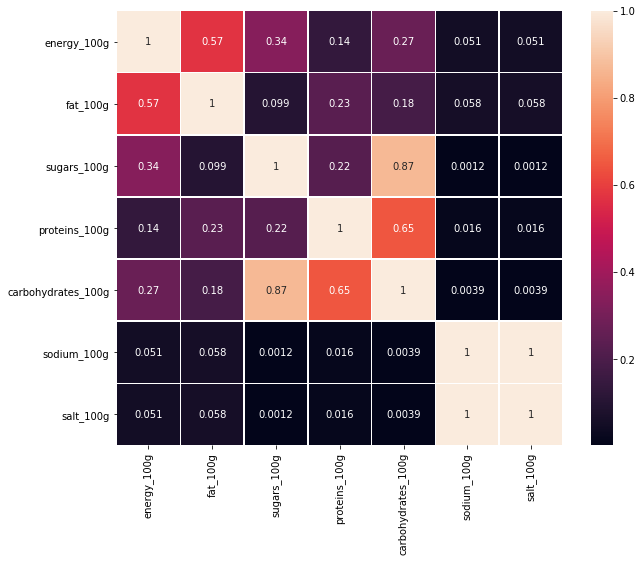

In [6]:
#correlation map in all the data set:a really general overview
#scatter plot,  box plot
#pca
dataPandasCorrelate=dataPandas[dataPandas.columns[1:-1]]
plt.figure(figsize=(10,8))
sns.heatmap(dataPandasCorrelate.corr(), annot = True, linewidths=.5)

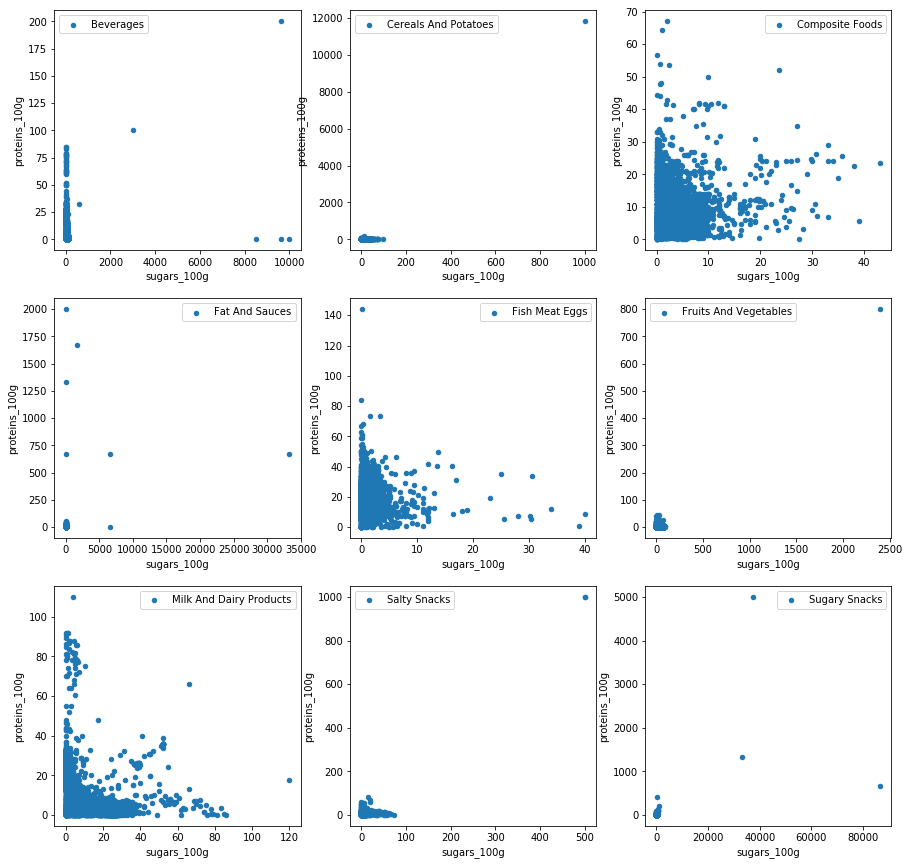

In [7]:
#looking inside for each categories of food we can see that the correleration can completely be different 
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(dataPandas.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='sugars_100g',y='proteins_100g',ax=ax[i // 3][i % 3],label=name)
    
plt.show()    
    
    
    


#from a first view of the plot, we can see that there are inconsistencies: for exmaple the number of fat can not
#exceed the 100g and the energy should not be bigger than 4000-5000 calories considering that in a g of 
#fat is equivalent to 9 calories, so we decide to constain our data

In [94]:
#constrain the data : energy<5000 and fat<100

def filterData(dataPandas,ParameterEnergy,Parameter):
    columns=dataPandas.filter(regex='_100g').columns
    for i in columns:
        if i=='energy_100g':
            dataPandas[i]=dataPandas[i][dataPandas[i]<ParameterEnergy]
        else:
            dataPandas[i]=dataPandas[i][dataPandas[i]<Parameter]
    return dataPandas


dataPandas=filterData(dataPandas,5000,100).dropna(how='all') #cleaning part 3

In [95]:
dataPandas

,pnns_groups_1,energy_100g,fat_100g,sugars_100g,proteins_100g,carbohydrates_100g,sodium_100g,salt_100g,product_name,packaging,ingredients_from_palm_oil_tags
0,Milk And Dairy Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sundae Mix,"Plastique,Carton",NaN
1,Cereals And Potatoes,1657.0,11.10,15.10,8.300,63.70,0.673228,1.71000,Gluten Free Melba Toasts With Apricots & Cashe...,"Carton,boîte",NaN
2,Composite Foods,862.0,7.10,2.30,11.200,23.00,0.354331,0.90000,Sandwich Poulet Rôti & Avocat,"Frais,plastique",NaN
3,Fat And Sauces,213.0,0.50,7.20,1.300,10.00,2.283465,5.80000,Tabasco Chipotle,"boîte,carton,bouteille,verre",NaN
4,Sugary Snacks,1916.0,17.10,40.80,4.800,70.80,0.236220,0.60000,Cookies soft baked,NaN,huile-de-palme
5,Sugary Snacks,1670.0,7.50,55.00,0.000,85.00,0.000000,0.00000,Starburst Original,box,NaN
6,Fruits And Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strawberries,NaN,NaN
7,Cereals And Potatoes,1142.0,3.60,5.30,11.400,46.80,0.314961,0.80000,5 Sesame Seed Bagels,"Sachet,plastique",NaN
8,Cereals And Potatoes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,King syrup Golden,NaN,NaN
9,Beverages,17.0,0.10,0.70,0.000,0.70,0.039370,0.10000,Blackcurrant High Juice,"bouteille,plastique",NaN


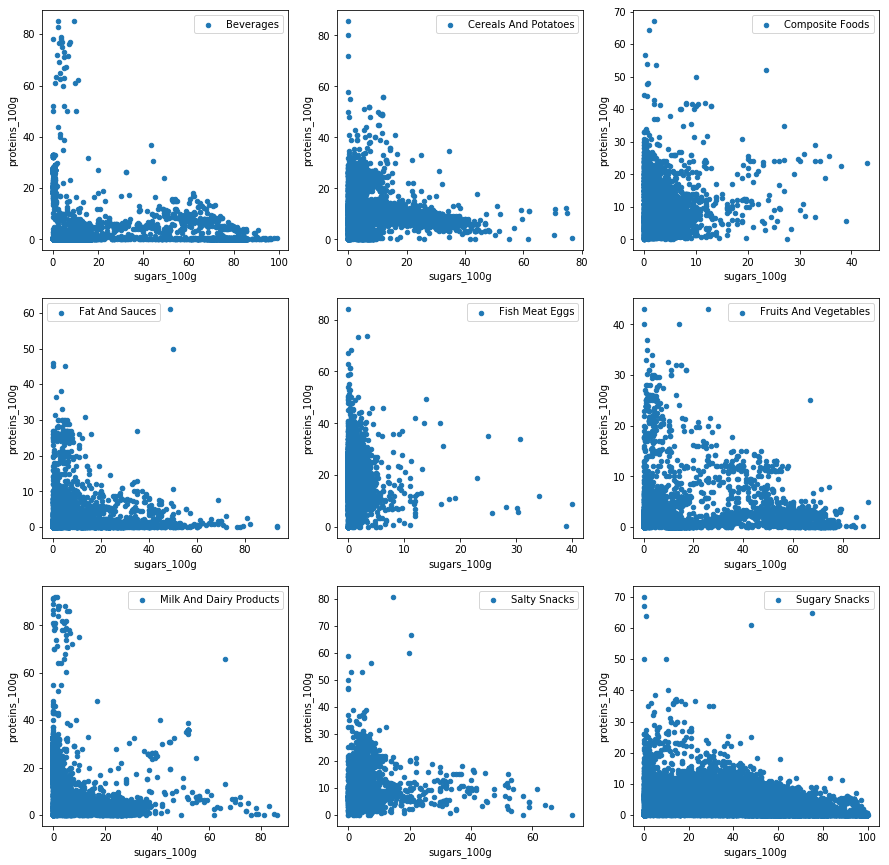

In [96]:
#replot after cleaning

fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(dataPandas.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='sugars_100g',y='proteins_100g',ax=ax[i // 3][i % 3],label=name)
    
plt.show()    
    
#even if there are Nan values they are not considered in the plot
 

In [307]:
#in order to look inside at which features could be more discriminative among the different groups, we
#decide to perform a PCA.
#import plotly
#from plotly.graph_objs import *
#import plotly.tools as tls

# visualization for the 9 groups the distribution of the 7 features


TypeError: 'numpy.dtype' object is not callable

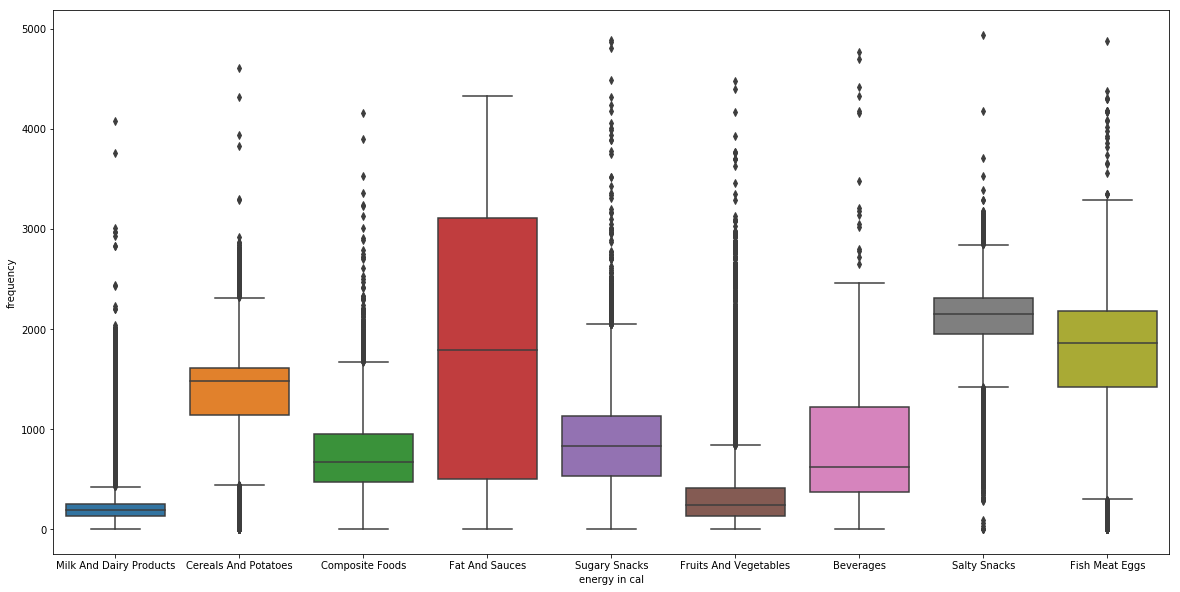

In [322]:
fig,ax=plt.subplots(figsize=(20,10))
data=[]
for i, (name, group) in enumerate(dataPandas[['pnns_groups_1','energy_100g']].groupby('pnns_groups_1')):
    data.append(group['energy_100g'].values)
    
data=np.asarray(data)    
g=sns.boxplot(data=data)
plt.xticks(plt.xticks()[0],dataPandas.pnns_groups_1.unique())
plt.xlabel('energy in cal')
plt.ylabel('frequency')
plt.show()

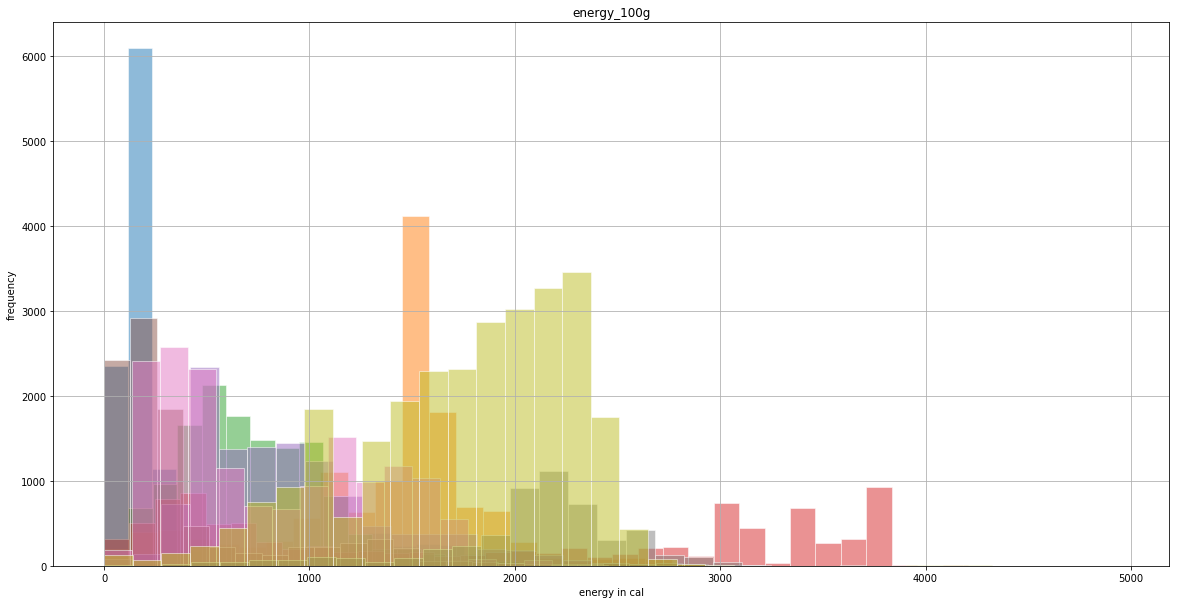

In [170]:
fig,ax=plt.subplots(figsize=(20,10))
for name, group in dataPandas[['pnns_groups_1','energy_100g']].groupby('pnns_groups_1'):
    group.hist(stacked=True, column='energy_100g', ax=ax,  histtype='bar', edgecolor='white',\
             alpha=0.5,bins=35,label=name )
#plt.legend(dataPandas.pnns_groups_1.unique())
plt.xlabel('energy in cal')
plt.ylabel('frequency')
plt.show()
#it's not easy to understand-> a lot of overlapping also in other features--> visible fat and sauces


In [23]:
#some analysis
dataPandas.groupby('pnns_groups_1').describe()

carbohydrates_100g                                     \
                                     count       mean        std   min    25%   
pnns_groups_1                                                                   
Beverages                             37.0  36.731892  29.764561  0.08   5.60   
Cereals And Potatoes                 611.0  58.496072  18.613723  3.30  53.00   
Composite Foods                      527.0  20.805844  14.475776  0.40  10.55   
Fat And Sauces                       213.0   4.540615  11.760024  0.00   0.00   
Fish Meat Eggs                        40.0   9.930000  16.508851  0.00   1.00   
Fruits And Vegetables                 48.0  24.550625  22.317931  3.50   5.60   
Milk And Dairy Products              181.0  29.524144  11.089432  1.50  22.70   
Salty Snacks                         241.0  52.386929  15.641183  4.10  45.00   
Sugary Snacks                       3356.0  59.254306  11.555473  1.00  52.40   

                                            energy_100g               ...   \
                           50%    75%   max       count         mean  ...    
pnns_groups_1                                                         ...    
Beverages                45.00  53.00  96.9        37.0  1076.329730  ...    
Cereals And Potatoes     64.60  70.00  87.0       611.0  1669.459902  ...    
Composite Foods          20.00  26.05  78.0       527.0   870.080266  ...    
Fat And Sauces            0.50   1.20  62.4       213.0  1923.859155  ...    
Fish Meat Eggs            1.95  15.00  69.2        40.0  1265.575000  ...    
Fruits And Vegetables     8.35  40.00  82.0        48.0  1067.916667  ...    
Milk And Dairy Products  31.00  36.50  60.0       181.0  1062.029282  ...    
Salty Snacks             55.00  63.00  93.3       241.0  2034.016598  ...    
Sugary Snacks            59.00  66.00  99.0      3356.0  1958.777130  ...    

                        sodium_100g            sugars_100g             \
                                75%        max       count       mean   
pnns_groups_1                                                           
Beverages                  0.314961   0.598425        37.0  24.629730   
Cereals And Potatoes       0.551181  10.590551       611.0  13.599903   
Composite Foods            0.511811   4.800000       527.0   2.984710   
Fat And Sauces             0.433071   6.181102       213.0   2.037329   
Fish Meat Eggs             0.875984   3.937008        40.0   3.305500   
Fruits And Vegetables      0.393701  12.913386        48.0  11.666042   
Milk And Dairy Products    0.090600   1.377953       181.0  22.184420   
Salty Snacks               0.866142   2.598425       241.0   5.275519   
Sugary Snacks              0.275591  19.685039      3356.0  36.979926   

                                                                       
                               std   min     25%    50%     75%   max  
pnns_groups_1                                                          
Beverages                22.657038  0.08   4.700  23.00  32.000  84.8  
Cereals And Potatoes     11.305075  0.00   3.550   9.38  24.000  62.0  
Composite Foods           3.977907  0.00   1.100   2.20   3.400  38.0  
Fat And Sauces            6.500001  0.00   0.000   0.45   0.500  61.3  
Fish Meat Eggs            8.283336  0.00   0.500   1.00   1.250  40.0  
Fruits And Vegetables    17.493267  0.00   1.375   2.95  15.000  76.0  
Milk And Dairy Products   8.776247  0.00  17.000  25.00  27.400  53.4  
Salty Snacks              5.770007  0.00   1.700   4.00   6.500  53.8  
Sugary Snacks            14.879157  0.00  27.600  35.15  48.925  97.0  

[9 rows x 56 columns]

In [48]:
X=dataPandas.iloc[:,1:8].values
y=dataPandas.iloc[:,0].values#LABELS
y

array(['Salty Snacks', 'Salty Snacks', 'Sugary Snacks', ...,
       'Fat And Sauces', 'Fruits And Vegetables', 'Composite Foods'],
      dtype=object)

In [72]:
#pca
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [77]:
Y_sklearn

array([[ 1.53723191,  1.92906754, -0.95915845],
       [ 2.96554782,  3.15077375, -0.51466198],
       [-1.27850778, -0.72541256,  1.44445414],
       ...,
       [-0.07658981,  0.17704763, -3.87607124],
       [ 1.83942009, -3.19295244, -0.77312765],
       [ 2.33277183, -2.0393893 , -0.3831244 ]])

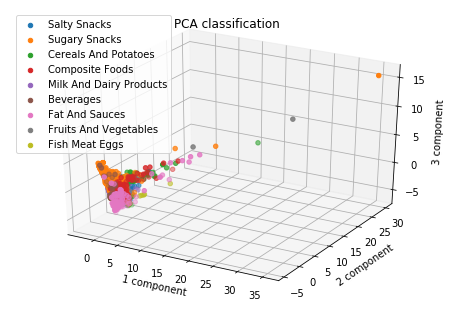

In [87]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)
#fig=plt.subplots(figsize=(10,10))
#ax=fig.gca(projection='3d')
for name in dataPandas.pnns_groups_1.unique():
        ax.scatter( 
            Y_sklearn[y==name,0],\
            Y_sklearn[y==name,1],
            Y_sklearn[y==name,2],
            label=name)
        
plt.legend()
pyplot.title('PCA classification')
pyplot.xlabel('1 component')
pyplot.ylabel('2 component')
ax.set_zlabel('3 component')
pyplot.show()

#no possible classification, the problem is given y the fact that this categorires are really general, 
#so for exammple bevareges can include not always water but also sugars drink like coca cole and so on..
#teh dataset should be more considered better

In [115]:
dataPandas[['pnns_groups_1','product_name']].groupby(['pnns_groups_1','product_name']).count()

Empty DataFrame
Columns: []
Index: [(Beverages,  Ginger drink ), (Beverages,  Pocket Raisin), (Beverages,  Pur jus de grenade bio ), (Beverages,  โค้ก ซีโร่), (Beverages, "Fruits de chez nous" poire de Provence), (Beverages, &quot;Fanta&quot; ( Pomme Cerise )), (Beverages, &quot;no Name&quot; Energy Drink), (Beverages, , Sirop de citron, la bouteille de 1 l), (Beverages, - Lait Chocolaté à Boire Bio & équitable - Grandeur Nature), (Beverages, 1 Paris-Brest), (Beverages, 1% Chocolate Lowfat Milk), (Beverages, 1/2 Reblochon de Savoie fruitier AOP lait cru 27%MG), (Beverages, 10 Gros Rochers Coco), (Beverages, 10 fruits & vitamines), (Beverages, 100 %  Pur Jus Pressé Orange (Avec Pulpe)), (Beverages, 100 %  pur jus ananas - citron vert), (Beverages, 100 % Juice Apple), (Beverages, 100 % Jus d'Orange Frais), (Beverages, 100 % Jus d'orange), (Beverages, 100 % Pur Fruit Pressé, Jus de raisin, de cranberry et purée de framboise ), (Beverages, 100 % Pur Jus Ananas), (Beverages, 100 % Pur Jus Clémentine), (Beverages, 100 % Pur Jus Clémentine Raisin Orange), (Beverages, 100 % Pur Jus Multifruits), (Beverages, 100 % Pur Jus Orange), (Beverages, 100 % Pur Jus Orange (Avec Pulpe)), (Beverages, 100 % Pur Jus Orange Pulpée Floride), (Beverages, 100 % Pur Jus Orange avec pulpe), (Beverages, 100 % Pur Jus Pamplemousse Blanc avec pulpe), (Beverages, 100 % Pur Jus Pamplemousse Rose), (Beverages, 100 % Pur Jus Pamplemousse Rose flash pasteurisé), (Beverages, 100 % Pur Jus Pamplemousse blanc), (Beverages, 100 % Pur Jus Pamplemousse rose (Avec Pulpe)), (Beverages, 100 % Pur Jus Pasteurisé de Raisin Rouges), (Beverages, 100 % Pur Jus Pomme), (Beverages, 100 % Pur Jus Pomme (Pur Fruit Pressé)), (Beverages, 100 % Pur Jus Raisin), (Beverages, 100 % Pur Jus d'Orange avec Pulpe), (Beverages, 100 % Pur Jus de Poire Biologique), (Beverages, 100 % Pur Jus orange (Avec Pulpe)), (Beverages, 100 % Pur Jus pomme), (Beverages, 100 % Pur Jus, Pamplemousse Blanc), (Beverages, 100 % Pur Jus, Raisin Blanc & Muscat), (Beverages, 100 % Pur fruit pressé, jus de pomme bio), (Beverages, 100 % Pur jus Orange), (Beverages, 100 % Pur jus d'orange avec pulpe flash pasteurisé réfrigéré), (Beverages, 100 % jus d'orange), (Beverages, 100 % pur fruit pressé, 4 agrumes), (Beverages, 100 % pur fruit pressé, Jus de pomme), (Beverages, 100 % pur fruit pressé, Jus de raisin bio), (Beverages, 100 % pur jus 4 agrumes), (Beverages, 100 % pur jus Ananas), (Beverages, 100 % pur jus Douceur du Matin), (Beverages, 100 % pur jus Orange avec pulpe), (Beverages, 100 % pur jus ananas), (Beverages, 100 % pur jus clémentines & mandarines pressées), (Beverages, 100 % pur jus d'orange avec pulpe), (Beverages, 100 % pur jus de pamplemousse vert), (Beverages, 100 % pur jus de pomme), (Beverages, 100 % pur jus orange), (Beverages, 100 % pur jus orange Floride), (Beverages, 100 % pur jus pasteurisé de pamplemousses roses pressés), (Beverages, 100 % pur jus pasteurisé multifruits), (Beverages, 100 % pur jus pomme), (Beverages, 100 % pur jus pomme framboise), (Beverages, 100 % pur jus pomme, poire, framboise), (Beverages, 100 % pur jus, Raisin), (Beverages, 100 % pur jus, raisin), (Beverages, 100 % грейпфрутовый сок), (Beverages, 100 Doses de Chocolat en Poudre), (Beverages, 100 pur jus orange avec pulpe), (Beverages, 100% Ananas), (Beverages, 100% Apple & Mango), (Beverages, 100% Apple Blends Juice), (Beverages, 100% Apple Cider Juice), (Beverages, 100% Apple Cider Juice From Concentrate), (Beverages, 100% Apple Juice), (Beverages, 100% Apple Juice From Concentrate), (Beverages, 100% Apple Juice From Concentrate With Added Ingredient), (Beverages, 100% Apple Juice From Organic Concentrate With Other Added Ingredients), (Beverages, 100% Apple Juice, Apple), (Beverages, 100% Apple Juice, Original), (Beverages, 100% Arancia), (Beverages, 100% Arancia Bionda), (Beverages, 100% Australian Grown Hand Picked Orange Juice), (Beverages, 100% Cranberry Juice & More), (Beverages, 100% FRUIT Jus d'orange douce ), (

In [126]:
#enviromental case
enviromentalData=dataPandas[['pnns_groups_1','packaging','ingredients_from_palm_oil_tags','product_name']]
enviromentalData[['pnns_groups_1','packaging']].groupby(['pnns_groups_1','packaging']).count()
enviromentalData[['pnns_groups_1','packaging']].groupby('packaging').count()

,pnns_groups_1
packaging,
",SIG",1
",becher",4
",becher,Becher",1
",becher,becher",1
",beutel",1
",bouteille",1
",bouteille en verre",1
",bouteille plastique",1
",boîte",1


In [125]:
enviromentalData['packaging'].unique()
#use regex to make good categories: PET/PLASTIQUE/Kuntstoff, VERRE/Becher,TETRAPACK, CARTON/papier in all the languages and even symbol

array(['Plastique,Carton', 'Carton,boîte', 'Frais,plastique', ...,
       'Carton,Boîte,carton,sachet papier,Boite carton à recycler,pièce',
       'Kuntstoff', 'carton,Sans BPA'], dtype=object)

AttributeError: 'numpy.ndarray' object has no attribute 'values'